# 🚀 1D Rocket Nozzle Simulation (Isentropic Flow)
### By Andrew Kesler • Aerospace Engineering @ UC Berkeley

Simulates Mach number, pressure, temperature, and velocity through a converging-diverging nozzle using isentropic flow equations.

This simulation models airflow through a converging-diverging nozzle—the same type used in rocket engines—to show how Mach number, pressure, and velocity change along its length. It assumes steady, isentropic (no heat loss or friction), compressible flow of air.
> 🔍 **Why this matters:**  
This model simulates how real rocket nozzles transition from subsonic to supersonic flow.  
It's based on principles used in designing nozzles for rockets like **Falcon 9**, **Starship**, and **RS-25**.  
Understanding isentropic flow and nozzle geometry is critical in maximizing thrust efficiency in aerospace propulsion systems.

In [118]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-dark')

# Purpose for STEP 1:
These define the fluid properties of air and initial conditions:

gamma is the specific heat ratio for air (ideal gas assumption).

R is the specific gas constant.

T0 and P0 are the total (stagnation) temperature and pressure, representing upstream flow before acceleration.

In [119]:
# STEP 1. Define Constants

gamma = 1.4  # specific heat ratio for air
R = 287.0    # specific gas constant for air in J/(kg·K)
T0 = 300.0   # stagnation temperature in K
P0 = 101325.0  # stagnation pressure in Pa

# Purpose for STEP 2:

We model a 1-meter long nozzle with 100 discrete positions.

The area function nozzle_area(x) creates a bell-shaped nozzle (minimum at center), representing the throat where flow becomes sonic.

This setup is essential to analyze how area changes affect Mach number.

In [123]:
# Nozzle area distribution (simple bell shape)
def nozzle_area(x):
    return 1 + 2.2 * (x - 0.5)**2

A = nozzle_area(x)
A_star = np.min(A)
A_ratio = A / A_star

# Purpose for STEP 3:
This numerically solves for the Mach number at each point in the nozzle using the area-Mach number relation:

def area_mach_relation(M, gamma=1.4):
    term1 = 1 / M
    term2 = ((gamma + 1) / 2) * (1 + ((gamma - 1) / 2) * M**2)
    exponent = (gamma + 1) / (2 * (gamma - 1))
    return term1 * term2**exponent
 
The equation can't be solved algebraically, so Newton-Raphson iteration is used.

We choose subsonic or supersonic solutions depending on whether we are before or after the throat.

This step is the core of the simulation—it determines how fast the flow is moving at every point.

📐 Governing Equation
\[
\frac{A}{A^*} = \frac{1}{M} \left[ \frac{\gamma+1}{2} \left(1 + \frac{\gamma - 1}{2} M^2 \right) \right]^{\frac{\gamma + 1}{2(\gamma - 1)}}
\]

In [157]:
# STEP 2. Define Nozzle Geometry

# Length of nozzle
length = 1.0  # in meters
n_points = 100
x = np.linspace(0, length, n_points)

### 📐 Governing Equation
\[
\frac{A}{A^*} = \frac{1}{M} \left[ \frac{\gamma+1}{2} \left(1 + \frac{\gamma - 1}{2} M^2 \right) \right]^{\frac{\gamma + 1}{2(\gamma - 1)}}
\]

In [124]:
# STEP 3. Solve for Mach Number (Isentropic flow)

def solve_mach(area_ratio, gamma=1.4, supersonic=True, tol=1e-6, max_iter=100):
    # Initial guess
    M = 2.0 if supersonic else 0.2
    
    for _ in range(max_iter):
        f = ((1 / M) * ((2 / (gamma + 1)) * (1 + (gamma - 1) / 2 * M**2))**((gamma + 1) / (2 * (gamma - 1)))) - area_ratio
        df = (-((2 / (gamma + 1)) * (1 + (gamma - 1) / 2 * M**2))**((gamma + 1) / (2 * (gamma - 1))) / M**2 +
              ((1 / M) * ((2 / (gamma + 1)) * (1 + (gamma - 1) / 2 * M**2))**((gamma + 1) / (2 * (gamma - 1))) *
               ((gamma + 1) / (gamma - 1)) * ((gamma - 1) * M / (1 + (gamma - 1) / 2 * M**2))))
        
        M_new = M - f / df
        if abs(M_new - M) < tol:
            return M_new
        M = M_new
    return M  # fallback

# Compute Mach number array
Mach = np.array([solve_mach(ar, supersonic=(xi > 0.5)) for xi, ar in zip(x, A_ratio)])

# Purpose for STEP 4:
Using the calculated Mach numbers, we compute:

Static Temperature (T): how cold/hot the flow gets due to expansion/compression.

Static Pressure (P): how pressure drops as speed increases.

Density (ρ): via the ideal gas law.

Velocity (V): from Mach number and local temperature.

These are standard isentropic relations from compressible flow theory.

In [126]:
# STEP 4. Calculate Flow Properties

T = T0 / (1 + (gamma - 1) / 2 * Mach**2)
P = P0 / (1 + (gamma - 1) / 2 * Mach**2)**(gamma / (gamma - 1))
rho = P / (R * T)
V = Mach * np.sqrt(gamma * R * T)

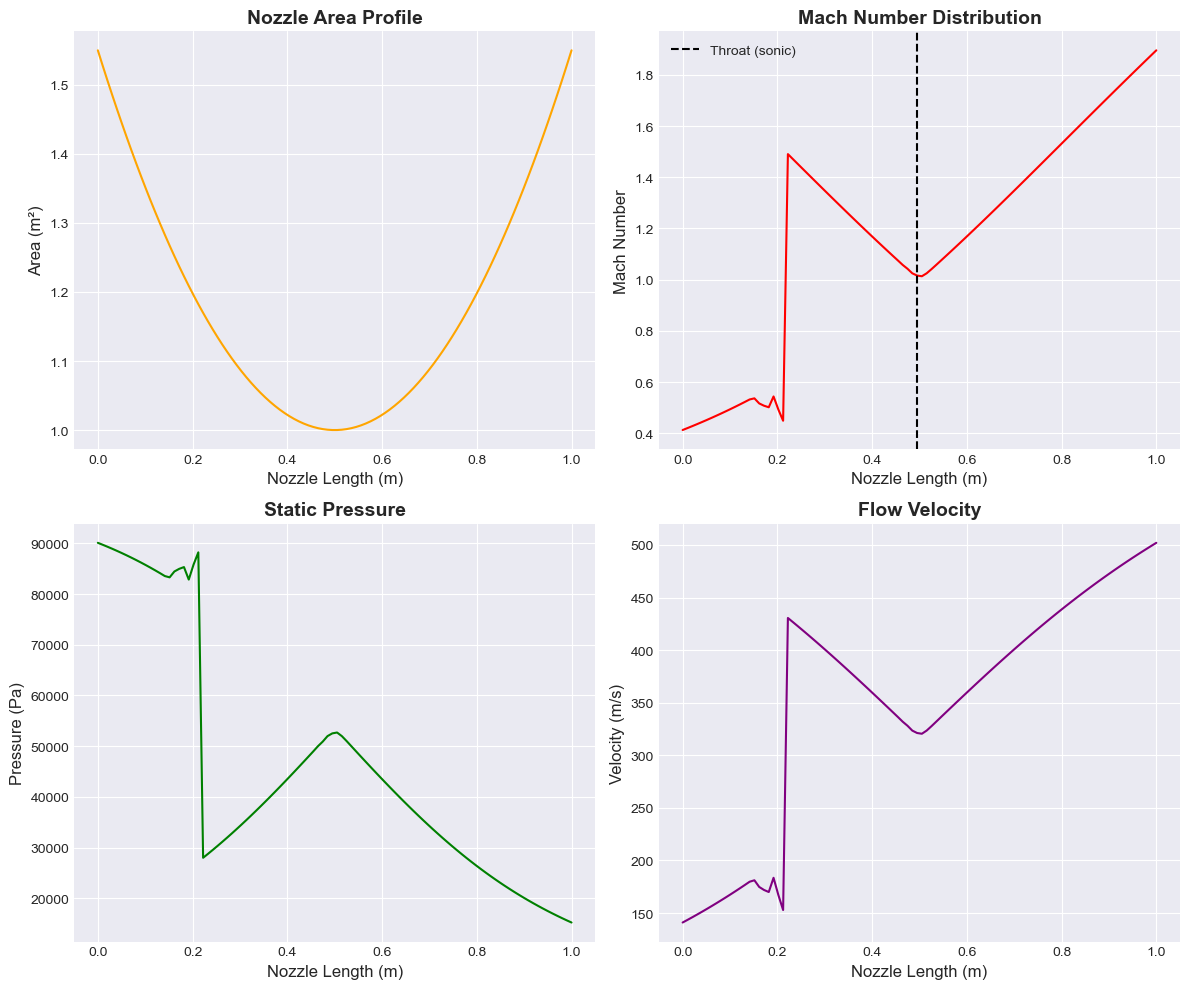

In [140]:
# STEP 5. Plot Results

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(x, A, color='orange')
plt.title("Nozzle Area Profile", fontsize=14, fontweight='bold')
plt.xlabel("Nozzle Length (m)", fontsize=12)
plt.ylabel("Area (m²)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(x, Mach, color='red')
plt.title("Mach Number Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Nozzle Length (m)", fontsize=12)
plt.ylabel("Mach Number", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
throat_index = np.argmin(A)
plt.axvline(x[throat_index], color='k', linestyle='--', label='Throat (sonic)')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(x, P, color='green')
plt.title("Static Pressure", fontsize=14, fontweight='bold')
plt.xlabel("Nozzle Length (m)", fontsize=12)
plt.ylabel("Pressure (Pa)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(x, V, color='purple')
plt.title("Flow Velocity", fontsize=14, fontweight='bold')
plt.xlabel("Nozzle Length (m)", fontsize=12)
plt.ylabel("Velocity (m/s)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()


# Purpose for STEP 5:
We visualize:

Nozzle area profile (how it narrows and expands)

Mach number (shows subsonic → sonic → supersonic transition)

Pressure (should drop along nozzle)

Velocity (should increase toward exit)

These plots let us analyze and verify how nozzle design affects performance—a key part of rocket propulsion design.

In [129]:
# Get values at the nozzle exit (last point)
exit_mach = Mach[-1]
exit_pressure = P[-1]
exit_velocity = V[-1]

print(f"Mach at exit: {exit_mach:.2f}")
print(f"Pressure at exit: {exit_pressure:.0f} Pa")
print(f"Velocity at exit: {exit_velocity:.1f} m/s")

Mach at exit: 1.90
Pressure at exit: 15223 Pa
Velocity at exit: 502.0 m/s


## 🧠 Final Notes

This simulation confirms expected flow behavior:
- Subsonic → sonic → supersonic transition
- Pressure and temperature drop as velocity increases

✅ Future improvements:
- Add shock wave detection  
- Model real gas effects  
- Add nozzle thrust estimation